# Package Installation and Loading


Main packages to analyse the persistent homology of the network dataset are: ripser, persim and NetworkX.    
**ripser**: A lean python package for analysing persistent homology. (Builds on c++ Ripser library).   
**persim**: A python package for analyzing persistence diagrams generated from ripser.   
**NetworkX**: NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.


In [ ]:
! pip3 install ripser

In [ ]:
! pip3 install giotto-tda

In [5]:
import pandas as pd
import numpy as np
import networkx as nwx
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
from scipy import stats
from igraph import Graph
from IPython.display import SVG, display
import matplotlib.pyplot as plt
from pyvis.network import Network

We are fetching the raw data directly from the GCN study repository (temporarily). We should update these datasets from the original sources as new data became available for both the PPI network and the CORUM Human complexes.


In [ ]:
! wget https://raw.githubusercontent.com/hars-singh/GCN_complex_detection/main/Datasets/Human/CORUM-Human-Complexes_r.txt

/bin/bash: wget: command not found


In [ ]:
! wget https://raw.githubusercontent.com/hars-singh/GCN_complex_detection/main/Datasets/Human/GOSemSim_Wang_combined_BIOGRID-ORGANISM-Homo_sapiens.txt -O Human_PPI_Network.txt

/bin/bash: wget: command not found


# Exploring PPI Network Data

In [6]:
## Here we load the PPI network data. The dataset is constructed by combinging BioGrid data for potein interaction pairs,
## with their GO Semantic Similarity score calulated using Wang method. (Wang. 2007)
ppi_df = pd.read_table("../data/Human_PPI_Network.txt", header=None)
ppi_df.columns = ["ProteinA", "ProteinB", "SemSim"]

## The GO Semantic Similarity score range from 0.0 to 1.0 from lowest to highest level of similarity
ppi_df.head()

,ProteinA,ProteinB,SemSim
0,FLNC,MAP2K4,0.672667
1,ACTN2,MYPN,0.738667
2,ACVR1,FNTA,0.370000
3,PML,GATA2,0.632667
4,STAT3,RPA2,0.576000


In [7]:
## Get unique proteins from the PPI Network file
ppi_single_proteins_m = ppi_df['ProteinA'].unique()
ppi_single_proteins_n = ppi_df['ProteinB'].unique()
ppi_single_proteins = set(ppi_single_proteins_m).union(set(ppi_single_proteins_n))
len(ppi_single_proteins)

17739

1.0
0.0
0.466
0.4292673173552603


{'whiskers': [<matplotlib.lines.Line2D at 0x28a1c3110>,
 'caps': [<matplotlib.lines.Line2D at 0x28a1a0250>,
 'boxes': [<matplotlib.lines.Line2D at 0x28a1c2810>],
 'medians': [<matplotlib.lines.Line2D at 0x28a1a1210>],
 'fliers': [<matplotlib.lines.Line2D at 0x28a1a1a50>],
 'means': []}

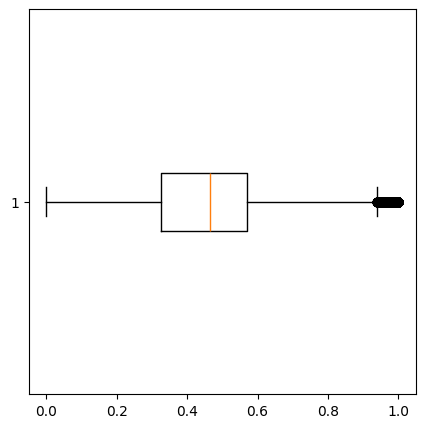

In [54]:
## Check the weight distribution on the nodes across the network
biogrid_semsim = np.array(ppi_df['SemSim'])
box_fig = plt.figure(figsize =(5, 5))

print(np.max(biogrid_semsim))
print(np.min(biogrid_semsim))
print(np.median(biogrid_semsim))
print(np.mean(biogrid_semsim))

plt.boxplot(biogrid_semsim, vert=False)

## Testing NetworkX Package on PPI Data

In [67]:
biogrid_protein_net = nwx.from_pandas_edgelist(
    ppi_df,
    source='ProteinA',
    target='ProteinB',
    edge_attr='SemSim'
)

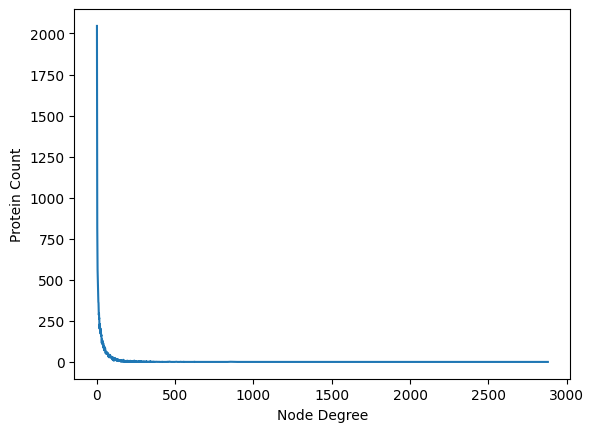

In [68]:
## Node Degree Viualization
## The following is a fucntion just to check the distribution of the node degrees. As it seems like there are highly central nodes
def viz_degree(network_graph):
  degree_nodes = {}
  for p, d in network_graph.degree():
    degree_nodes[p] = d

  ## This gives that there are nodes with degree > 900
  sorted_node_degrees = dict(sorted(degree_nodes.items(), key=lambda item: item[1],  reverse=True))

  ## Let's visualize the distribution
  viz_degree = {degree: 0 for degree in degree_nodes.values()}
  for degree in degree_nodes.values():
    viz_degree[degree]+=1
  degree_count_pairs = sorted(viz_degree.items())
  x, y = zip(*degree_count_pairs) # unpack a list of pairs into two tuples
  plt.plot(x, y)
  plt.xlabel('Node Degree')
  plt.ylabel('Protein Count')
  plt.show()

viz_degree(biogrid_protein_net)

Maximum single node degree:  2879
Minimum single node degree:  1
Degree median:  15.0
Average node degree:  38.21218783471447
Node degree mode:  1


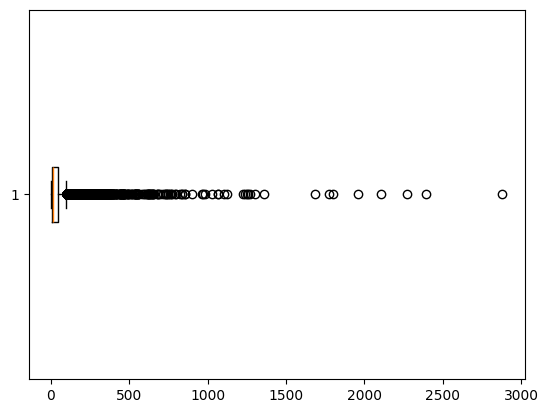

In [73]:
## Exploring the node edge distribution
biogrid_net_degrees = []
for prot, degree in biogrid_protein_net.degree():
    biogrid_net_degrees.append(degree)

print('Maximum single node degree: ', np.max(biogrid_net_degrees))
print('Minimum single node degree: ', np.min(biogrid_net_degrees))
print('Degree median: ', np.median(biogrid_net_degrees))
print('Average node degree: ', np.mean(biogrid_net_degrees))
print('Node degree mode: ', stats.mode(biogrid_net_degrees)[0])

#plt.figure(figsize =(5, 5))
biogrid_degree_boxplot = plt.boxplot(biogrid_net_degrees, vert=False)

In [93]:
print(sorted(biogrid_degree_boxplot['fliers'][0].get_data()[0])[0])

100


In [78]:
## We have 1494 outliers with high node-degree numbers
print(len(biogrid_degree_boxplot['fliers'][0].get_data()[0]))

1494


In [81]:
biogrid_net_outliers = []
for prot, degree in biogrid_protein_net.degree():
    if degree >= 100:
        biogrid_net_outliers.append(prot)

# Exploring Protein Complexes Data
This data was collected from the CORUM database. These are from the 3.0 database and were downloaded directly from the Github repository for the study. We should refer to the latest CORUM 4.0 update for a more comprehensive list of complexes.


In [84]:
complexes_list = []
with open("../data/CORUM_Human_Complexes.txt") as complexes:
  for line in complexes:
    line = line.strip()
    temp_list = list(line.split("\t"))
    complexes_list.append(temp_list)

In [12]:
print(len(complexes_list))
## We have 2645 protein complexes

2645


In [16]:
# Check the largest complex
largest_idx = 0
for idx, cmplx in enumerate(complexes_list):
  if len(cmplx) > len(complexes_list[largest_idx]):
    largest_idx = idx
print("The largest protein complex is at idx %d and has %d proteins." % (largest_idx, len(complexes_list[largest_idx])))
# The largest Protein Complex includes 143 individual proteins at index 171.

The largest protein complex is at idx 171 and has 143 proteins.


In [17]:
## We should first explore the individual proteins first
## Get unique proteins from the Complexes file
## Check common proteins
complexes_dict = {}
complexes_single_proteins = []
for idx, cmplx in enumerate(complexes_list):
  for protein in cmplx:
    if protein not in complexes_single_proteins:
      complexes_single_proteins.append(protein)

  complexes_dict[idx] = cmplx

print(len(complexes_single_proteins))

3634


In [85]:
## This checks which proteins from the complexes that we have exist in the PPI network data that we have
## We can see that there are 3544 out of the 3634 unique complexes proteins that have PPI data
common_proteins = ppi_single_proteins.intersection(complexes_single_proteins)
len(common_proteins)

3544

In [37]:
## We see that 97.52% of the proteins in the complexes have interaction data in the Biogrid dataframe
print(3544/3634*100)

97.52339020363236


In [89]:
## Let's see how many of the outliers we found in the biogrid network (considered hub-proteins?) are in the complexes
biogrid_cmplxs_outliers = set(biogrid_net_outliers).intersection(complexes_single_proteins)
len(biogrid_cmplxs_outliers)

974

In [90]:
## ~27% of the proteins in the complexes are considered outliers in the biogrid data
print(974/3634*100)

26.802421574023118


## Exploring Complexes Network

In [95]:
cmplxs_exclusive_net_df = ppi_df[(ppi_df['ProteinA'].isin(complexes_single_proteins)) & (ppi_df['ProteinB'].isin(complexes_single_proteins))]
cmplxs_exclusive_net_df.head()

,ProteinA,ProteinB,SemSim
4,STAT3,RPA2,0.576000
12,TFAP2A,EP300,0.635333
19,BCL3,BARD1,0.648667
20,ADRB1,GIPC1,0.495333
22,BRCA1,MSH2,0.604333


In [98]:
cmplxs_exclusive_net = nwx.from_pandas_edgelist(
    cmplxs_exclusive_net_df,
    source='ProteinA',
    target='ProteinB',
    edge_attr='SemSim'
)

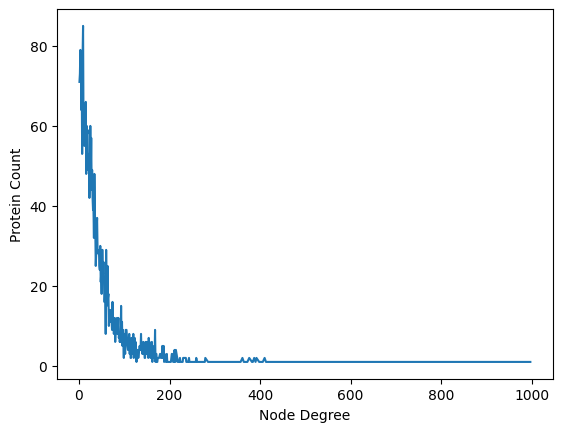

In [99]:
viz_degree(cmplxs_exclusive_net)

1.0
0.0
0.543333333333
0.5401833535154366


{'whiskers': [<matplotlib.lines.Line2D at 0x2931c7e50>,
 'caps': [<matplotlib.lines.Line2D at 0x291397910>,
 'boxes': [<matplotlib.lines.Line2D at 0x2931c7cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x288907210>],
 'fliers': [<matplotlib.lines.Line2D at 0x2923a3450>],
 'means': []}

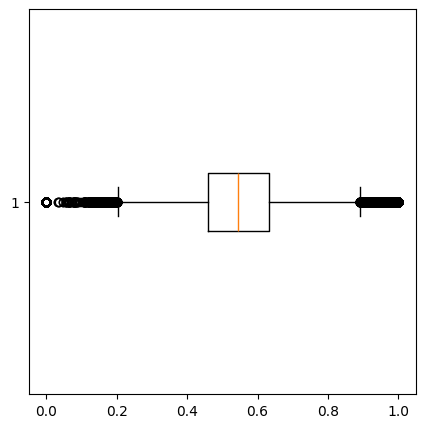

In [100]:
## We see here that the SemSim average is higher than the 0.42 of the overall Biogrid network, as expected
cmplxs_exclusive_semsim = np.array(cmplxs_exclusive_net_df['SemSim'])

print(np.max(cmplxs_exclusive_semsim))
print(np.min(cmplxs_exclusive_semsim))
print(np.median(cmplxs_exclusive_semsim))
print(np.mean(cmplxs_exclusive_semsim))

box_fig = plt.figure(figsize =(5, 5))
plt.boxplot(cmplxs_exclusive_semsim, vert=False)

## Exploring Complexes Proteins Sub-Network

In [27]:
## Let's filter out some data for proteins found in the complexes and see how the distributions change.
## Keeping in mind that we also have proteins in the network here interacting with complex-specific proteins.
biogrid_cmplxs_ppi_df_source = ppi_df[(ppi_df['ProteinA'].isin(complexes_single_proteins))]
biogrid_cmplxs_ppi_df_target = ppi_df[(ppi_df['ProteinB'].isin(complexes_single_proteins)) ]
biogrid_cmplxs_ppi_df = pd.concat([biogrid_cmplxs_ppi_df_source, biogrid_cmplxs_ppi_df_target])
biogrid_cmplxs_ppi_df.drop_duplicates()
biogrid_cmplxs_ppi_df.head(10)


,ProteinA,ProteinB,SemSim
3,PML,GATA2,0.632667
4,STAT3,RPA2,0.576000
5,ARF1,GGA3,0.447000
9,APP,APPBP2,0.408333
11,TFAP2A,CITED2,0.677333
12,TFAP2A,EP300,0.635333
14,ARRB2,RALGDS,0.741333
15,GRB2,CSF1R,0.619667
17,LSM1,NARS,0.462333
18,SLC4A1,SLC4A1AP,0.507333


In [28]:
biogrid_cmplxs_ppi_net = nwx.from_pandas_edgelist(
    biogrid_cmplxs_ppi_df,
    source='ProteinA',
    target='ProteinB',
    edge_attr='SemSim'
)

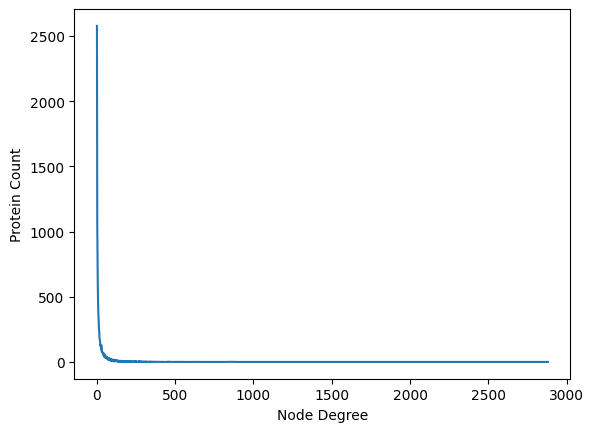

In [29]:
viz_degree(biogrid_cmplxs_ppi_net)

1.0
0.0
0.508666666667
0.4844463197802568


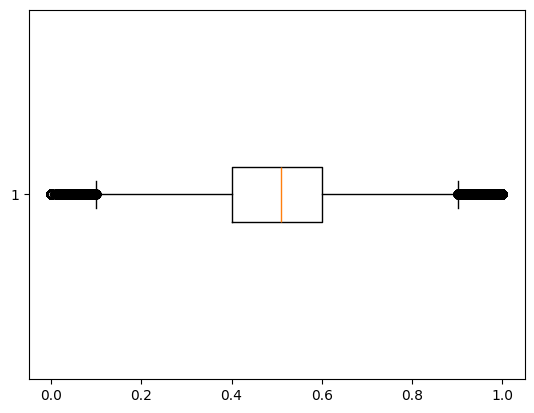

In [101]:
## Checking the weight distributions on the complexes
biogrid_cmplxs_semsim = np.array(biogrid_cmplxs_ppi_df['SemSim'])

print(np.max(biogrid_cmplxs_semsim))
print(np.min(biogrid_cmplxs_semsim))
print(np.median(biogrid_cmplxs_semsim))
print(np.mean(biogrid_cmplxs_semsim))

box_fig = plt.boxplot(biogrid_cmplxs_semsim, vert=False)

In [38]:
biogrid_cmplxs_degree = []
for prot, degree in biogrid_cmplxs_ppi_net.degree():
    biogrid_cmplxs_degree.append(degree)

In [39]:
print(np.max(biogrid_cmplxs_degree))
print('The 25th and 75th percentile for the node degrees are: ', np.percentile(biogrid_cmplxs_degree, [25, 75]))
print(np.min(biogrid_cmplxs_degree))
print(np.median(biogrid_cmplxs_degree))
print(np.mean(biogrid_cmplxs_degree))
print(stats.mode(biogrid_cmplxs_degree))
print(nwx.average_clustering(biogrid_cmplxs_ppi_net))

2879
The 25th and 75th percentile for the node degrees are:  [ 2.5 26. ]
1
8.0
30.067403382379876
ModeResult(mode=1, count=2578)
0.1676152383895184


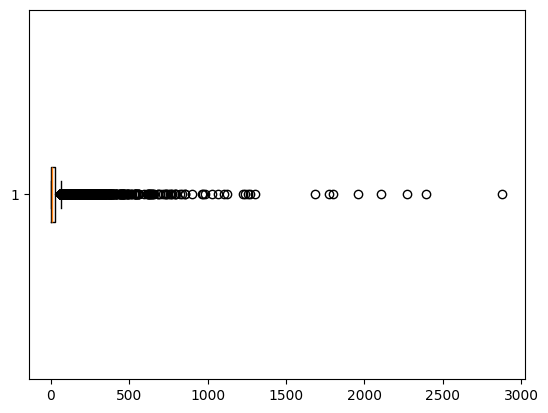

In [44]:
biogrid_cmplxs_degree_boxplot = plt.boxplot(biogrid_cmplxs_degree, vert=False)

In [92]:
## We have 1916 with relatively higher degrees that we consider outliers
print(sorted(biogrid_cmplxs_degree_boxplot['fliers'][0].get_data()[0])[0])
print(len(sorted(biogrid_cmplxs_degree_boxplot['fliers'][0].get_data()[0])))

62
1916


In [ ]:
## Let's collect those outliers and see how they match up to the 
biogrid_cmplxs_outliers = []
for prot, degree in biogrid_cmplxs_ppi_net.degree():
    if degree >= 62:
        biogrid_cmplxs_outliers.append(prot)
        print('{0} has degree {1}'.format(prot, degree))

In [61]:
len(biogrid_cmplxs_outliers)

1916

In [63]:
for prot in biogrid_cmplxs_outliers:
    biogrid_cmplxs_ppi_net.remove_node(prot)

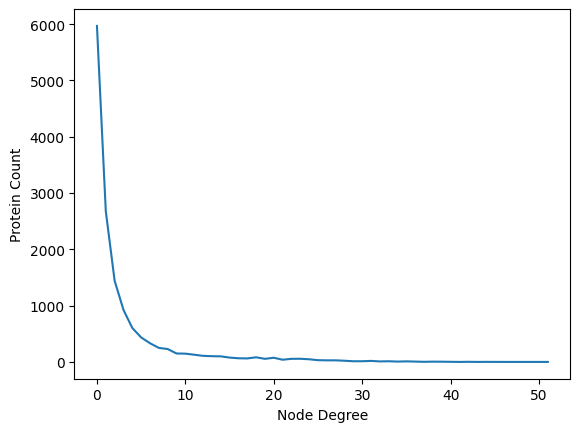

In [64]:
viz_degree(biogrid_cmplxs_ppi_net)

# Adjacency Matrix Transformation
We can exploit the vietoris rips packages used for feature extraction for the NN models, but we need to wrangle the graph into and adjacency matrix. This would enable us to feed it into the giotto-tda package. We should also generate these matrices to feed into the GCN models.


## Adjacency Matrix Transformation

### Approach 1
This approach takes way too long to compute the adjacency matrix, had to make it a bit more dynamic and split the search time over different iterations

In [ ]:
common_proteins_indices = {}
for idx, protein in enumerate(common_proteins):
  common_proteins_indices[protein] = idx


In [ ]:
common_proteins_neighbors = {}

for protein in common_proteins:
  neighbors = list(ppi_df[ppi_df['ProteinA'] == protein]['ProteinB'])
  common_proteins_neighbors[protein] = list(set(neighbors) & set(common_proteins))

  #for neighbor in neighbors:
   # common_proteins_neighbors[protein]  = list.append((common_proteins_indices[neighbor], ppi_df[(ppi_df['ProteinA'] == protein) & (ppi_df['ProteinB'] == neighbor)]['SemSim']))

In [ ]:
m = 3544
adjacency_mat = [[0] * m] * m

In [ ]:
for protein in common_proteins_neighbors:
  neighbors = common_proteins_neighbors[protein]
  for neighbor in neighbors:
    adjacency_mat[common_proteins_indices[protein]][common_proteins_indices[neighbor]] = 1

In [ ]:
for protein in common_proteins:
  neighbors = list(ppi_df[ppi_df['ProteinA'] == protein]['ProteinB'])
  #neighbors = common_proteins_neighbors[protein]
  for neighbor in neighbors:
    if neighbor in common_proteins:
      adjacency_mat[common_proteins_indices[protein]][common_proteins_indices[neighbor]] = ppi_df[(ppi_df['ProteinA'] == protein) & (ppi_df['ProteinB'] == neighbor)]['SemSim']

### Approach 2
The previous approach is very computationally costly, as such we will try to optimize it to a more basic one.

In [ ]:
## Extract PPI Unique proteins from the set
ppi_unique_proteins = np.unique(ppi_df[['ProteinA', 'ProteinB']])
n_proteins = len(ppi_unique_proteins)
print(f'We have %d unique proteins in the PPI dataset' % n_proteins )

We have 17739 unique proteins in the PPI dataset


In [ ]:
## Create a hashmap of protein to idx so that we could identify them in the matrix
protein_to_idx = {protein: idx for idx, protein in enumerate(ppi_unique_proteins)}

In [ ]:
## Initialize Adjacency Matrix
## IMPORTANT NOTE: This was initialized with np.inf for inexistent edges esepecially for the Giotto-TDA package
adj_mat = np.matrix(np.ones((n_proteins, n_proteins)) * np.inf)

In [ ]:
for idx, row in ppi_df.iterrows():
  protein_A = protein_to_idx[row['ProteinA']]
  protein_B = protein_to_idx[row['ProteinB']]
  sem_sim_score = row['SemSim']
  adj_mat[protein_A, protein_B] = sem_sim_score
  adj_mat[protein_B, protein_A] = sem_sim_score

In [ ]:
## File is too large to save into a tsv, so i will make the matrix sparse instead
np.savetxt('ppi_adj_mat.tsv',adj_mat,delimiter='  ')

In [ ]:
## In the interest of saving memory, converting the matrix to sparse row format with scipy might be a good idea
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
adj_mat_sparse = csr_matrix(adj_mat)

In [ ]:
## save_npz exports the matrix to an npz file, to load it back, use the load_npz method.
save_npz('sparse_matrix.npz', adj_mat_sparse)